# Accessing data on Object Store from any platform

## Objective: The purpose of this notebook is to demonstrate how to access data stored on Object Storage.
### This notebook will work on three different platforms (DataLabs, JASMIN Notebook Service and Google Colab). To use this notebook please select the following python environments:
- DataLabs: Python 3 (ipykernel)
- JASMIN Notebook Service: Python 3 + Jaspy
- Google Colab*: Default environment
*For running this notebook in Google Colab, please remember to create a copy of the notebook before running it. Then the associated catalogue yaml (catalogue_temperature.yaml) file should be uploaded to the file system, otherwise the notebook will fail.

## Install the required packages
### Install the required packages using the following command after selecting the basic python3 envionments listed in the cell above based on the platform you are using. Although we do not set up virtual environment for this notebook, if needed, please read the following links for more details on setting up virtual environments on the different platforms:
- DataLabs: https://datalab-docs.datalabs.ceh.ac.uk/tutorials/getting-started-jupyter/create-conda-environment.html
- JASMIN Notebook Service: https://help.jasmin.ac.uk/article/5084-creating-a-virtual-environment-in-the-jasmin-notebooks-service
- Google Colab: https://colab.research.google.com/drive/1Vg005uKhgt-ZwyQ11-BGceqY0q07qIzF

In [1]:
!pip install s3fs zarr intake intake-xarray

##  Import the required packages

In [2]:
import numpy as np
import pandas as pd
import intake
import intake_xarray
import s3fs
import xarray as xr
from datetime import datetime
import io
import json
import requests
import zipfile
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Accessing Station Observations
### We will be accessing observed variable of Daily Maximum Temperature Air (TA_MAX) from 2016--2022 for one of the COSMOS station (ALIC1) directly from COSMOS API

In [3]:
# Pre-written functions for accessing COSMOS data.
# Please see https://cosmos-api.ceh.ac.uk/python_examples for code examples
# Please see https://cosmos-api.ceh.ac.uk/docs for more details


def get_api_response(url, csv=False):
    """Helper function to send request to API and get the response

    :param str url: The URL of the API request
    :param bool csv: Whether this is a CSV request. Default False.
    :return: API response
    """
    # Send request and read response
    print(url)
    response = requests.get(url)

    if csv:
        return response
    else:
        # Decode from JSON to Python dictionary
        return json.loads(response.content)


def get_collection_parameter_info(params):
    """A function for wrangling the collection information into a more visually appealing format!"""
    df = pd.DataFrame.from_dict(params)
    df = df.T[["label", "description", "unit", "sensorInfo"]]

    df["unit_symbol"] = df["unit"].apply(lambda x: x["symbol"]["value"])
    df["unit_label"] = df["unit"].apply(lambda x: x["label"])
    df["sensor_depth"] = df["sensorInfo"].apply(
        lambda x: None if pd.isna(x) else x["sensor_depth"]["value"]
    )

    df = df.drop(["sensorInfo", "unit"], axis=1)

    return df


def format_datetime(dt):
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")


def read_json_collection_data(json_response):
    """Wrangle the response JSON from a COSMOS-API data collection request into a more usable format - in this case a Pandas Dataframe

    :param dict json_response: The JSON response dictionary returned from a COSMOS-API data collection request
    :return: Dataframe of data
    :rtype: pd.DataFrame
    """
    # The response is a list of dictionaries, one for each requested site

    # You can choose how you want to build your dataframes.  Here, I'm just loading all stations into one big dataframe.
    # But you could modify this for your own use cases.  For example you might want to build a dictionary of {site_id: dataframe}
    # to keep site data separate, etc.
    master_df = pd.DataFrame()

    for site_data in resp["coverages"]:
        # Read the site ID
        site_id = site_data["dct:identifier"]

        # Read the time stamps of each data point
        time_values = pd.DatetimeIndex(site_data["domain"]["axes"]["t"]["values"])

        # Now read the values for each requested parameter at each of the time stamps
        param_values = {
            param_name: param_data["values"]
            for param_name, param_data in site_data["ranges"].items()
        }

        # And put everything into a dataframe
        site_df = pd.DataFrame.from_dict(param_values)
        site_df["datetime"] = time_values
        site_df["site_id"] = site_id

        site_df = site_df.set_index(["datetime", "site_id"])
        master_df = pd.concat([master_df, site_df])

    return master_df

In [4]:
# We need to extract "ta_max" parameter for COSMOS station "ALIC1" over the period of 2016 -- 2022
start_date = format_datetime(datetime(2016, 1, 1))
end_date = format_datetime(datetime(2022, 12, 31))
query_date_range = f"{start_date}/{end_date}"
param_name = [
    "ta_max",
]
site_nm = "ALIC1"

In [5]:
# First we get the metadata for the COSMOS station
BASE_URL = "https://cosmos-api.ceh.ac.uk"
site_info_url = f"{BASE_URL}/collections/1D/locations"
site_info_response = get_api_response(site_info_url)

site_info = {}
for site in site_info_response["features"]:
    site_id = site["id"]
    site_name = site["properties"]["label"]
    coordinates = site["geometry"]["coordinates"]
    date_range = site["properties"]["datetime"]
    start_date, end_date = date_range.split("/")

    other_info = site["properties"]["siteInfo"]
    other_info = {key: d["value"] for key, d in other_info.items()}

    site_info[site_id] = {
        "site_name": site_name,
        "coordinates": coordinates,
        "start_date": start_date,
        "end_date": end_date,
    } | other_info

site_info_df = pd.DataFrame.from_dict(site_info).T
s_df = site_info_df[site_info_df.index == site_nm]
s_df

https://cosmos-api.ceh.ac.uk/collections/1D/locations


,site_name,coordinates,start_date,end_date,altitude,bulk_density,bulk_density_sd,land_cover,lattice_water,lattice_water_sd,soil_organic_carbon,soil_organic_carbon_sd,soil_type
ALIC1,Alice Holt,"[51.153551, -0.858232]",2015-03-06T13:30:00Z,2023-11-16T00:00:00Z,80.0,0.84,None,Broadleaf woodland,0.025,None,0.042,None,Mineral soil


In [6]:
# Extracting the COSMOS station latitude and longitude from the whole metadata list
# COSMOS station latitude and longitude is required to calculate the nearest grid point on the CHESS grid to extract corresponding model data
site_latitude = s_df["coordinates"][0][0]
site_longitude = s_df["coordinates"][0][1]
print(
    "COMOS Site "
    + site_nm
    + " Latitude: "
    + str(site_latitude)
    + " Longitude: "
    + str(site_longitude)
)

COMOS Site ALIC1 Latitude: 51.153551 Longitude: -0.858232


/tmp/ipykernel_1224/733139797.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  site_latitude = s_df["coordinates"][0][0]
/tmp/ipykernel_1224/733139797.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  site_longitude = s_df["coordinates"][0][1]


In [7]:
# Extracting COSMOS TA_MAX data for the station over the required period into a pandas dataframe
query_url = f'{BASE_URL}/collections/1D/locations/{site_nm}?datetime={query_date_range}&parameter-name={",".join(param_name)}'
resp = get_api_response(query_url)
df = read_json_collection_data(resp)
df = df.reset_index()
display(df)
print(df.shape)

https://cosmos-api.ceh.ac.uk/collections/1D/locations/ALIC1?datetime=2016-01-01T00:00:00Z/2022-12-31T00:00:00Z&parameter-name=ta_max


,datetime,site_id,ta_max
0,2016-01-01 00:00:00+00:00,ALIC1,8.6
1,2016-01-02 00:00:00+00:00,ALIC1,10.7
2,2016-01-03 00:00:00+00:00,ALIC1,8.9
3,2016-01-04 00:00:00+00:00,ALIC1,9.7
4,2016-01-05 00:00:00+00:00,ALIC1,8.2
...,...,...,...
2552,2022-12-27 00:00:00+00:00,ALIC1,10.3
2553,2022-12-28 00:00:00+00:00,ALIC1,11.4
2554,2022-12-29 00:00:00+00:00,ALIC1,9.7
2555,2022-12-30 00:00:00+00:00,ALIC1,12.6


(2557, 3)


In [8]:
# Calculating monthly climatological values of TA_MAX for the station over 2016--2022
df_site = (
    df.groupby(pd.PeriodIndex(df["datetime"], freq="M"))["ta_max"].mean().reset_index()
)
df_site["datetime"] = df_site.datetime.dt.to_timestamp()
df_site = df_site.groupby(df_site["datetime"].dt.month).mean("ta_max")
df_site

,ta_max
datetime,
1,7.479724
2,8.883418
3,10.689401
4,13.544762
5,17.071429
6,19.841905
7,21.749462
8,21.487097
9,18.777143


## Accessing Model Data from JASMIN Object Store
### In this notebook we will be accessing CHESS-SCAPE data that has been stored in the JASMIN Object Store tenancy and made open READ access to all. For more information about CHESS-SCAPE data, please see https://catalogue.ceda.ac.uk/uuid/8194b416cbee482b89e0dfbe17c5786c. We will be extracting the Daily Maximum Surface Air Temperature (TASMAX) at the grid point nearest to the COSMOS Station ALIC1 for the period 2016--2022 for all ensemble members available. 

### Exploring the bucket with s3fs

In [9]:
# s3fs is a python package that allows you to not only read the data but also explore the tenancy (chess-scape-o)
# Here we will be using s3fs to list the bucket and not read the data, we read the data using intake package shown below
# For more information please see: https://pypi.org/project/s3fs/
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': "https://chess-scape-o.s3-ext.jc.rl.ac.uk"})
s3.ls('s3://ens01-year100kmchunk/')
# In the output you see that within in the chess-scape-o tenancy, a bucket called ens01-year100kmchunk
# has 10 different zarr files for different 10 different variables. This is for a single chunk type tested.

['ens01-year100kmchunk/hurs_01_year100km.zarr',
 'ens01-year100kmchunk/huss_01_year100km.zarr',
 'ens01-year100kmchunk/pr_01_year100km.zarr',
 'ens01-year100kmchunk/psurf_01_year100km.zarr',
 'ens01-year100kmchunk/rlds_01_year100km.zarr',
 'ens01-year100kmchunk/rsds_01_year100km.zarr',
 'ens01-year100kmchunk/sfcWind_01_year100km.zarr',
 'ens01-year100kmchunk/tmax_01_year100km.zarr',
 'ens01-year100kmchunk/tmean_01_year100km.zarr',
 'ens01-year100kmchunk/tmin_01_year100km.zarr']

### Setup Intake Catalogue

In [10]:
# The intake catalogue defines the endpoints that should be used to access specific datasets on the object storage.
# For any dataset that is not open READ access, you would also need to provide required credentials
catalogue = intake.open_catalog("./catalogue.yaml")
catalogue

catalogue:
  args:
    path: ./catalogue.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### Accessing data for the ensemble members and the associated metadata
#### We have not activated any Dask Cluster for this notebook. This notebook will run without any Dask Cluster activated. However, if a Dask Cluster is available on the platform you are using, you may initalise a dask client and the rest of the notebook will run as the same. For using Dask Client on the different platforms, please see the links below:
- DataLabs: https://datalab-docs.datalabs.ceh.ac.uk/tutorials/datalabs-dask-cluster/index.html
- JASMIN Notebook Service: https://github.com/cedadev/jasmin-daskgateway
- Google Colab: https://saturncloud.io/docs/using-saturn-cloud/external-connect/colab_external_connect/

In [11]:
# We are accessing TASMAX for the Ensemble member #01 from the catalogue
# We are using the mid-sized chunk type for the dataset
# For more information about different chunk sizes and their performance, please see the GitHub README.
chess_data_01 = catalogue.e01_tmax_year100km.to_dask()
chess_data_01

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.Dataset>
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * time     (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
  * y        (y) float32 500.0 1.5e+03 2.5e+03 ... 1.054e+06 1.056e+06 1.056e+06
Data variables:
    lat      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    tasmax   (time, y, x) float32 dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          4.7.3
    contact:      emrobi@ceh.ac.uk
    history:      Fri Mar 19 15:18:41 2021: cdo --sortname -add /gws/nopw/j04...
    institution:  CEH Wallingford - NERC
    project:      UK-SCAPE: SPEED

In [12]:
# CHESS-SCAPE is on the British National Grid with Easting and Northing Coordinates.
# We also set the latitude and longitude as coordinates
chess_data_01 = chess_data_01.set_coords(("lat", "lon"))
chess_data_01

<xarray.Dataset>
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time     (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
  * y        (y) float32 500.0 1.5e+03 2.5e+03 ... 1.054e+06 1.056e+06 1.056e+06
Data variables:
    tasmax   (time, y, x) float32 dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          4.7.3
    contact:      emrobi@ceh.ac.uk
    history:      Fri Mar 19 15:18:41 2021: cdo --sortname -add /gws/nopw/j04...
    institution:  CEH Wallingford - NERC
    project:      UK-SCAPE: SPEED

In [13]:
# Slicing for the time period 2016--2022
chess_data_01 = chess_data_01["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))
chess_data_01

<xarray.DataArray 'tasmax' (time: 2520, y: 1057, x: 656)>
dask.array<getitem, shape=(2520, 1057, 656), dtype=float32, chunksize=(360, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time     (time) object 2016-01-01 12:00:00 ... 2022-12-30 12:00:00
  * x        (x) float32 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
  * y        (y) float32 500.0 1.5e+03 2.5e+03 ... 1.054e+06 1.056e+06 1.056e+06
Attributes:
    long_name:      Maximum air temperature
    standard_name:  air_temperature
    units:          K

In [14]:
# Extracting data for the other ensemble members
# Ensemble member #04
chess_data_04 = catalogue.e04_tmax_year100km.to_dask()
chess_data_04 = chess_data_04.set_coords(("lat", "lon"))
chess_data_04 = chess_data_04["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))

# Ensemble member #06
chess_data_06 = catalogue.e06_tmax_year100km.to_dask()
chess_data_06 = chess_data_06.set_coords(("lat", "lon"))
chess_data_06 = chess_data_06["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))

# Ensemble member #15
chess_data_15 = catalogue.e15_tmax_year100km.to_dask()
chess_data_15 = chess_data_15.set_coords(("lat", "lon"))
chess_data_15 = chess_data_15["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))

### Deriving the Observed Station nearest grid point on the Gridded Dataset

In [15]:
# Function to derive the data for the nearest grid point to the station lat lon
def find_chess_tile(lat, lon, latlon_ref):
    """
    Created by Doran Khamis (dorkha@ceh.ac.uk)
    Function to calculate the nearest grid point
    of a given lat lon value within a gridded dataset
    The input data is the latitude, longitude of the station
    and the grid reference (latlon_ref) of the gridded dataset
    The function returns the y and x index for the gridded dataset
    which can be used to derive the nearest grid point
    This function assumes equal length lat/lon vectors in latlon_ref
    """
    dist_diff = np.sqrt(
        np.square(latlon_ref.lat.values - lat) + np.square(latlon_ref.lon.values - lon)
    )
    chesstile_yx = np.where(dist_diff == np.min(dist_diff))
    return chesstile_yx

In [16]:
# We create a temporary CHESS-SCAPE gridded dataset array
chess_tmp = chess_data_01[0, :, :]
chess_tmp

<xarray.DataArray 'tasmax' (y: 1057, x: 656)>
dask.array<getitem, shape=(1057, 656), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    time     object 2016-01-01 12:00:00
  * x        (x) float32 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
  * y        (y) float32 500.0 1.5e+03 2.5e+03 ... 1.054e+06 1.056e+06 1.056e+06
Attributes:
    long_name:      Maximum air temperature
    standard_name:  air_temperature
    units:          K

In [17]:
# Extracting the x and y indices which point to the nearest grid point of the COSMOS station
y, x = find_chess_tile(site_latitude, site_longitude, chess_tmp)
print(y, x)

[140] [479]


In [18]:
# Deleting the temporary array
del chess_tmp

### Extracting the model ensemble data for the grid point nearest to the observed station

In [19]:
# Creating arrays for day, month and year from the time index
day = np.array([i.day for i in chess_data_01.time.values])
month = np.array([i.month for i in chess_data_01.time.values])
year = np.array([i.year for i in chess_data_01.time.values])

In [20]:
# Indexing the CHESS-SCAPE data with the x and y coordinates nearest to the observed station
ens = ["ENS01", "ENS04", "ENS06", "ENS15"]
chess_site_data = np.zeros((len(ens), len(day)))
chess_site_data[0, :] = chess_data_01[:, y, x].squeeze().values
chess_site_data[1, :] = chess_data_04[:, y, x].squeeze().values
chess_site_data[2, :] = chess_data_06[:, y, x].squeeze().values
chess_site_data[3, :] = chess_data_15[:, y, x].squeeze().values

In [21]:
# Converting CHESS-SCAPE temperature from Kelvin to deg Celsius
chess_site_data = chess_site_data - 273.15

In [22]:
# Creating a pandas dataframe for CHESS-SCAPE ensemble TASMAX
f = np.vstack((year, month, day, chess_site_data))
df = pd.DataFrame(f.T, columns=["YEAR", "MONTH", "DAY"] + ens)
df

,YEAR,MONTH,DAY,ENS01,ENS04,ENS06,ENS15
0,2016.0,1.0,1.0,8.469476,10.387781,2.881372,9.451196
1,2016.0,1.0,2.0,9.242853,8.467340,6.806024,10.261072
2,2016.0,1.0,3.0,10.037408,4.452875,5.930597,8.856165
3,2016.0,1.0,4.0,6.358728,4.522943,4.312189,6.318750
4,2016.0,1.0,5.0,6.984888,2.625421,1.373346,7.547205
...,...,...,...,...,...,...,...
2515,2022.0,12.0,26.0,11.695123,7.517450,10.040674,6.743341
2516,2022.0,12.0,27.0,7.335809,11.334253,9.427026,7.944208
2517,2022.0,12.0,28.0,10.932184,8.553369,5.844202,7.643549
2518,2022.0,12.0,29.0,10.518945,7.154962,7.586847,5.023523


In [23]:
# Calculating monthly climatology of TASMAX for all the ensemble members
df_model = df.groupby(["YEAR", "MONTH"])[ens].mean()
df_model = df_model.groupby(["MONTH"])[ens].mean()
df_model

,ENS01,ENS04,ENS06,ENS15
MONTH,,,,
1.0,8.199085,7.225493,7.370226,6.386664
2.0,7.908752,7.396607,6.743253,7.388288
3.0,10.210987,10.479619,9.844518,10.104133
4.0,12.819470,13.400659,12.973615,12.981180
5.0,16.253889,17.441104,16.428872,16.286755
6.0,20.577827,19.185257,20.710894,21.569696
7.0,23.490857,21.457086,25.016401,23.415034
8.0,23.007554,21.511500,25.052005,22.698149
9.0,20.052419,19.290494,20.566005,19.663535


### Comparing observations against modelled ensemble projection

In [24]:
# For plotting the data in the notebook
%matplotlib inline

In [25]:
# List of months
months = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]

In [26]:
# Calculating model ensemble mean, minimum and maximum
df_model_max = df_model.max(axis=1)
df_model_min = df_model.min(axis=1)
df_model_mn = df_model.mean(axis=1)

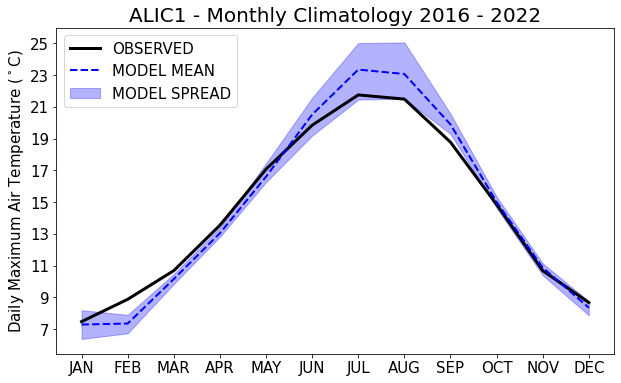

In [27]:
# Plotting monthly climatology of Daily Maximum Air Temperature from COSMOS station ALIC1 and nearest grid point on CHESS-SCAPE averaged over 2016--2022
fig = plt.figure(figsize=(10, 6))
plt.plot(months, df_site.values, color="k", lw=3, label="OBSERVED")
plt.plot(months, df_model_mn.values, color="b", ls="--", lw=2, label="MODEL MEAN")
plt.fill_between(
    months,
    df_model_min.values,
    df_model_max.values,
    color="b",
    alpha=0.3,
    label="MODEL SPREAD",
)
plt.ylabel("Daily Maximum Air Temperature ($^\circ$C)", fontsize=15)
plt.yticks(np.arange(7, 26, 2), fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.title(site_nm + " - Monthly Climatology 2016 - 2022", fontsize=20)
plt.show()